<a href="https://colab.research.google.com/github/dimalv/investment/blob/main/mortgage_rentability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mortgage Rentability
This notebook analyzes the profitability of buying an apartment or a house, and calculates when is it best doing so.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Constants
YEAR = 12  # months in one year

## Interest Calculations

#### Nominal v.s. Effective Interest
The yearly interest declared by banks is a nominal interest (12 times the monthly interest), which doesn's represent the true interest in a period of a year, because it neglects the monthly loan growth due to the interest and the loan decrease due to monthly paymets.

Another common parameter is an effective yearly interest, which takes into account the monthly loan increase, but it still doesn't take into account the monthly payments, thus it's even less accurate.

$$ \text{effective interest} = \left(1 + \frac{\text{nominal interest}}{12}\right)^{12} - 1 $$

However, the inverse relation can be used for calculation of an investment  interest knowing the effective yearly interest,

$$ \text{nominal interest} = \left( (1 + \text{effective interest})^{1/12} - 1 \right) \times 12 $$
$$ \text{monthly interest} = \frac{\text{nominal interest}}{12} = (1 + \text{effective interest})^{1/12} - 1 $$

In [3]:
def effective_to_monthly_interest(effective_yearly_interest):
  return (1 + effective_yearly_interest)**(1./12) - 1

#### Total Interest
Since the loan amount decreases with time, the interest payed to the banks also decreases. The important number is the total interest payed during the whole process of loan returning. In case of a constant monthly payment, the total interest for a loan of amount $L$ taken for $N$ months with $R$ monthly interest, is given by the following formula (see [Appendix - Constant Loan Payment](https://colab.research.google.com/drive/1z29Kp0Yyz_WOZspYomUh6BrIlcRlnyOj#scrollTo=wMf-Bo4JAp-F)),

$$\begin{align}
    R_{tot} &= NR\frac{(1 + R)^N}{(1 + R)^N - 1} - 1 \ ,
  \end{align} $$

and the total amount payed to the bank in return is $L(1+R_{tot})$.

In [4]:
def total_interest(monthly_interest, number_of_months):
  R = monthly_interest
  N = number_of_months
  return N*R*(1+R)**N/((1+R)**N - 1) - 1


def total_loan_payback(loan_amount, monthly_interest, number_of_months):
  return loan_amount * (1 + total_interest(monthly_interest, number_of_months))

## Best time to purchase
Having the option to purchase an apartment or a house we are often wondering whether it's better so save some more money first, to reduce the loan size and hence the interest we pay to the bank. This section deals with that question, providing a numerical simulation example.

### Optimization Goal
The optimization criterion used here is the total monetary value acheived after `TOTAL_YEARS` years, including assets and cash.

The optimized parameter is the time for purchasing a house or an apartment.

### Total Value Factors
The total value is formed from several different factors:

1. Saved money
2. Interest earned by investing your cash (in e.g. stocks)
3. Payed rent
4. Loan interest payed to the bank
5. Asset value increase

### Parameters
**Note**: All the monetary numbers are in thousands.

In [5]:
TOTAL_YEARS = 30
t = np.r_[:TOTAL_YEARS*YEAR]  # time vector [in months]

# Financial coefficients
mortgage_yearly_nominal_interest = 2.5 / 100
investment_yearly_effective_interest = 6. / 100

# Personal 
# --------
apart_price_effective_yearly_increase = 4. / 100  # estimation
starting_apart_price = 6000
owned_apartment_starting_price = 2300  # in case you now possess an apartment 
                                       # of a lower price.
starting_sum = 800  # the invested amount at time 0 (now), not including the 
                    # value of an apartment you own.

# The saving ability (income - expenses) vs time
saved_monthly = np.zeros_like(t)
saved_monthly[:2*YEAR] = 20
saved_monthly[2*YEAR:5*YEAR] = 20
saved_monthly[5*YEAR:] = 20

# Rent vs time (replaced by mortgage when a house is bougth)
rent = np.zeros_like(t)
rent[:4*YEAR] = 0
rent[4*YEAR:] = 0

In [6]:
# Monthly increase factors
investment_monthly_interest = effective_to_monthly_interest(
    investment_yearly_effective_interest)
apart_price_monthly_increase = effective_to_monthly_interest(
    apart_price_effective_yearly_increase)

total_months = TOTAL_YEARS * YEAR
months = np.r_[:total_months]
years = months / YEAR

### Total Value Calculation
Assuming everything you save is invested immediatly, the cash you have for the purchase v.s. the purchase time is,


In [7]:
# Savings and cash investment
saved_before_purchase = np.zeros(total_months)
saved_before_purchase[0] = starting_sum
for n in range(1, total_months):
    saved_before_purchase[n] = (
        saved_before_purchase[n-1] * (1 + investment_monthly_interest) +
        saved_monthly[n] - rent[n]
    )

The apartment price increases with time

In [8]:
apart_price_total_increase = (1 + apart_price_monthly_increase) ** months
apartment_price = starting_apart_price * apart_price_total_increase
final_apartment_price = apartment_price[-1]
owned_apartment_price = (owned_apartment_starting_price * 
                         apart_price_total_increase)

The loan amount, its time period and subsequently the monthly payment depend on the purchase time,

In [9]:
loan_taken = np.maximum(apartment_price - owned_apartment_price - 
                        saved_before_purchase, 0)
loan_payback_sum = total_loan_payback(
    loan_amount=loan_taken, 
    monthly_interest=mortgage_yearly_nominal_interest/YEAR,
    number_of_months=total_months-months
)
loan_monthly_payment = loan_payback_sum / (total_months-months)
bank_earning = loan_payback_sum - loan_taken

#### Can you pay off?
If the loan payment is greater than your monthly siving then you won't be able to pay the loan back, and the banks won't give you the loan.

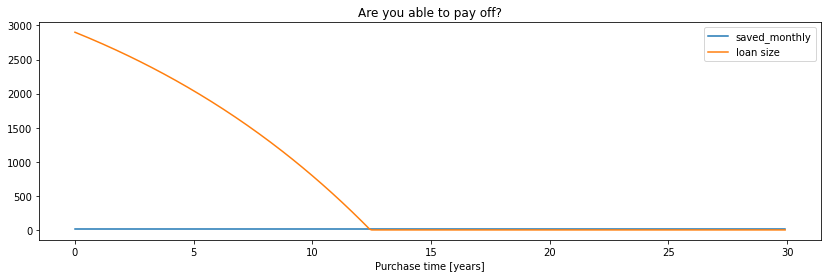

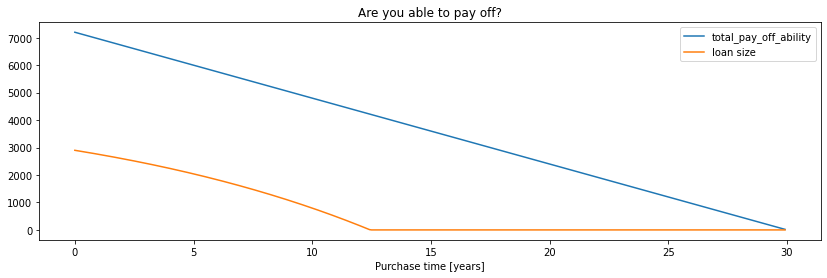

In [10]:
plt.figure(figsize=(14, 4))
plt.plot(years, saved_monthly, label='saved_monthly')
plt.plot(years, loan_taken, label='loan size')
plt.xlabel('Purchase time [years]')
plt.title('Are you able to pay off?')
_ = plt.legend()

total_pay_off_ability = np.cumsum(saved_monthly[::-1])[::-1]
np.any(total_pay_off_ability > loan_taken)
plt.figure(figsize=(14, 4))
plt.plot(years, total_pay_off_ability, label='total_pay_off_ability')
plt.plot(years, loan_taken, label='loan size')
plt.xlabel('Purchase time [years]')
plt.title('Are you able to pay off?')
_ = plt.legend()

#### Saving after the purchase
After the purchase you continue to save and invest your income, with the rent being replaced by the loan payments,

In [11]:
# Cash groth after purchase
cash_left_from_purchase = np.maximum(saved_before_purchase - apartment_price +
                                     owned_apartment_price, 0)
saved_after_purchase = cash_left_from_purchase
for purchase_time in range(total_months):
  for n in range(purchase_time, total_months):
    saved_after_purchase[purchase_time] = (
        saved_after_purchase[purchase_time] * (1 + investment_monthly_interest) 
        + saved_monthly[n] - loan_monthly_payment[n]
    )

Assuming the loan is covered after `TOTAL_YEARS` the value at that point is the apartment (final) price and the money you save after the purchase

In [12]:
# Total value after TOTAL_YEARS
total_value = final_apartment_price + saved_after_purchase

### >>>----> Results plot
Plotting some of the computed values on a chart,

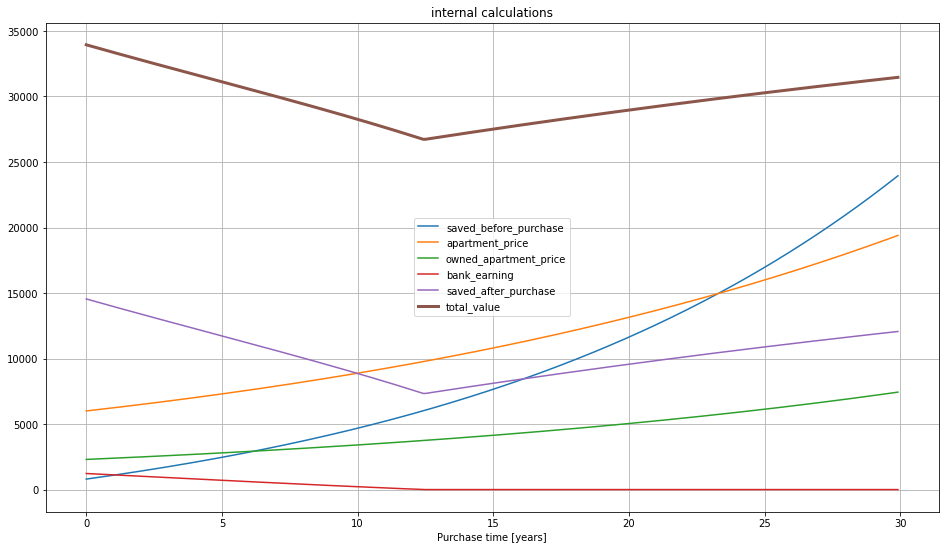

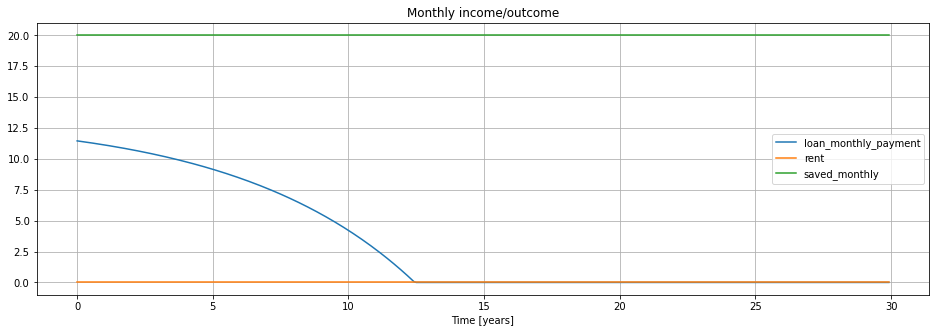

In [16]:
plt.figure(figsize=(16, 9))
plt.plot(years, saved_before_purchase, label="saved_before_purchase")
plt.plot(years, apartment_price, label="apartment_price")
plt.plot(years, owned_apartment_price, label="owned_apartment_price")
plt.plot(years, bank_earning, label='bank_earning')
plt.plot(years, saved_after_purchase, label='saved_after_purchase')
plt.plot(years, total_value, label='total_value', linewidth=3)
plt.xlabel('Purchase time [years]')
plt.title('internal calculations')
plt.legend()
plt.grid()

plt.figure(figsize=(16, 5))
plt.plot(years, loan_monthly_payment, label='loan_monthly_payment')
plt.plot(years, rent, label='rent')
plt.plot(years, saved_monthly, label='saved_monthly')
plt.xlabel('Time [years]')
plt.title('Monthly income/outcome')
plt.legend()
plt.grid()

## Appendix - Constant Loan Payment

This section explains the calculation of a constant payment against loan plus interest.

For initial loan amount $L$ taken for $N$ time periods (e.g. months) for an interest rate $R$ per period. Denoting by $l[n]$ the residual loan amount at period $n$, with a constant payment of $P$, the residual loan at period $n$ is recoursively described by,

$$\begin{align}
    &l[n] = l[n-1] \cdot (1+R) - P  \qquad: n = 1, 2, \dots, N \\
    &l[0] = L
  \end{align}$$



### Solution
Since the equation is linear, the solution can be factored into zero-state and zero-input parts,

$$ l[n] = l_{zs}[n] + l_{zi}[n] \ .$$

#### Zero-Input Solution
The sero-input part solves,

$$\begin{align}
    &l[n] = l[n-1] \cdot (1+R)  \qquad: n = 1, 2, \dots, N \\
    &l[0] = L \ ,
  \end{align}$$

in which case the solution is,

$$ l_{zi}[n] = L(1+R)^n \ .$$

#### Zero-State Solution
The zero-state part solves,

$$\begin{align}
    &l[n] = l[n-1] \cdot (1+R) - P  \qquad: n = 1, 2, \dots, N \\
    &l[0] = 0 \ .
  \end{align}$$

In this case the first several elements of the sequence are:

$$\begin{array}{l|l}
  n & l_{zs}[n] \\
  \hline
  0 & 0 \\
  1 & -P \\
  2 & -P(1+R) - P \\
  3 & -P(1+R)^2 - P(1+R) - P \\
  \end{array}$$

and in general,

$$ l_{zs}[n] = -P \sum_{i=0}^{n-1} (1+R)^i $$

or, using the formula of a geometric progression sum,

$$ l_{zs}[n] = -P \frac{1 - (1+R)^n}{1 - (1+R)} = -\frac{P}{R} \left( (1+R)^n - 1 \right)$$

#### Complete Solution
The complete solution is than obtained by adding the two parts,

$$ l[n] = L(1+R)^n - \frac{P}{R}((1+R)^n - 1) \ .$$

Let's verify it by plugging into the original formulation,

$$ l[n] = l[n-1] \cdot (1+R) - P $$
$$\begin{align}
  l[n-1] \cdot (1+R) - P 
    &= \Big( L(1+R)^{n-1} - \frac{P}{R}\big((1+R)^{n-1} - 1\big) \Big) (1+R) - P \\
    &= L(1+R)^{n} - \frac{P}{R}\big((1+R)^{n} - (1+R)\big) - P \\
    &= L(1+R)^{n} - \frac{P}{R}\big((1+R)^{n} - 1 - R\big) - P \\
    &= L(1+R)^{n} - \frac{P}{R}\big((1+R)^{n} - 1\big) + \frac{P}{R}R - P \\
    &= L(1+R)^{n} - \frac{P}{R}\big((1+R)^{n} - 1\big) \\
    &= l[n]
  \end{align} \\
  \blacksquare$$

### The Period Payment Amount
$ P $ is chosen such that $l[N] = 0$,

$$ L(1 + R)^N - \frac{P}{R}((1 + R)^N - 1) = 0 $$
$$ P = LR\frac{(1 + R)^N}{(1 + R)^N - 1} $$

### Total Interest Paid
For a loan of amount $L$ one pays $N$ payments of amount $P$, paying in total $NP$. What is the total interest then?

$$ NP = L(1+R_{tot}) \quad \longrightarrow \quad R_{tot} = \frac{NP}{L} - 1 $$

$$\begin{align}
    R_{tot} &= NR\frac{(1 + R)^N}{(1 + R)^N - 1} - 1
  \end{align} $$

### Numeric Verification

P = 9.426990170396044
R_tot = 0.13123882044752522
l[N] = 6.45350439754111e-11
NP - (1 + R_tot)*L = 0.0


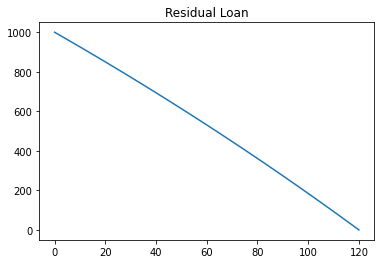

In [14]:
import numpy as np
from matplotlib import pyplot as plt

R = 2.5 / 100 / 12
L = 1000
N = 10 * 12

P = float(L*(1+R)**N*R)/((1+R)**N - 1)
R_tot = N*R*(1+R)**N/((1+R)**N - 1) - 1

l = np.zeros(N + 1)
l[0] = L
for n in range(N):
  l[n+1] = l[n]*(1+R) - P

plt.plot(l)
plt.title('Residual Loan')

print('P =', P)
print('R_tot =', R_tot)
print('l[N] =', l[N])
print('NP - (1 + R_tot)*L =', N*P - (1 + R_tot)*L)

## Appendix - Apartment Price Increase
The following chart shows a yearly apartment price increase in Israel in the recent years.
The data is taken from https://protocol.co.il/housing-price-index/

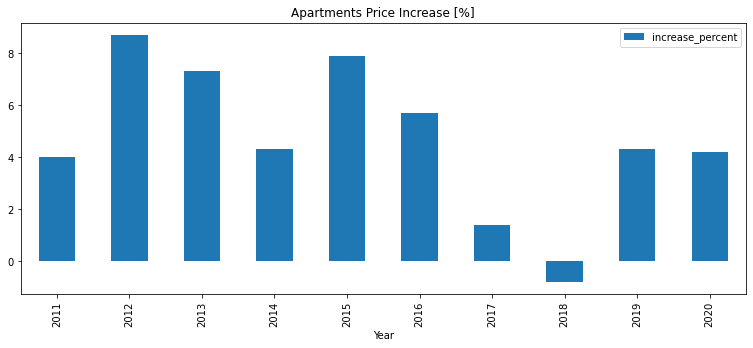

In [15]:
from pandas import DataFrame, DatetimeIndex

apartment_price_increase_data = DataFrame(
    data={'increase_percent': [4, 8.7, 7.3, 4.3, 7.9, 5.7, 1.4, -0.8, 4.3, 4.2]},
    index=list(range(2011, 2021))
    )
fig = plt.figure(figsize=(13, 5))
_ = apartment_price_increase_data.plot(
    ax=fig.gca(), 
    title='Apartments Price Increase [%]',
    xlabel='Year',
    kind='bar')